Notes:
> Version 1: Without Class weights and tested on the testing dataset. Works much better than the RGB dataset's model.

> Version 2: Loaded weights from previous version and retrained model using class weights. Tested by saving the model and loading the best saved weights. Satisfactory response. F1 scores for each class calculated. On average a difference of 0.2 between the validation and testing F1 score's.

> Version 3-6: SpectrumNet
     
    Version 3: No normalization
    Version 6: Standard Scaling
    Version 7: L2 normalization

* Model V5-4 : L2 Normalization
* Model V5-5 : Added more tiles to SeaLake [Version 10]
* Model V5-5.1 : Training only using CPU and Model V5-5 [Version 11]
* Model V5-5.2 : Training only using CPU and StandardScaler is used to normalise the data. [Version 12]

Issues:
 > Model confuses between PermanentCrop and HerbaceousVegetation.

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os, cv2, json, random, itertools, rasterio, math, time, psutil, warnings

# np.random.seed(0)
# tf.random.set_seed(0)

from tqdm import tqdm
from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot, to_categorical, Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import *

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense, Concatenate)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

from tensorflow.keras.preprocessing.image import img_to_array, load_img
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
warnings.filterwarnings("ignore")

# Running TensorBoard

# Utility Functions:

In [2]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], 'r-', label='Training Loss')
    ax[0].plot(history.history['val_loss'], 'g-', label='Validation Loss')
    ax[1].plot(history.history['categorical_accuracy'], 'r-', label='Training Accuracy')
    ax[1].plot(history.history['val_categorical_accuracy'], 'g-', label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show();
    pass

In [3]:
def plot_learning_rate(loss_history):
    
    plt.style.use("ggplot")
    
    plt.plot(np.arange(0,len(loss_history.lr)), loss_history.lr)
    plt.show();
    pass

In [4]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar();
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.0
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j,i, format(cm[i,j], fmt),
                horizontalalignment = 'center',
                color = "white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(False);
    pass

In [5]:
with open("../input/eurosat-dataset/EuroSATallBands/label_map.json","r") as f:
    class_names_encoded = json.load(f)
    pass

class_names = list(class_names_encoded.keys())
num_classes = len(class_names)
class_names_encoded

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [6]:
bands = {'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'8a':9,'9':10,'10':11,'11':12,'12':13}

## Defining Normalisation

In [7]:
def Normalise(arr_band):
    
    return StandardScaler().fit_transform(arr_band)

## Data Generator

In [8]:
basePath = "../input/eurosat-dataset/EuroSATallBands"

def data_generator(csv_file, num_classes, batch_size = 10, target_size = 64):
    i = 0
    classes = set()
    df = pd.read_csv(csv_file)
    num_samples = df.shape[0]
    
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples_idx = df.index[offset:offset+batch_size]

            X, y = [], []

            for i in batch_samples_idx:
                img_name = df.loc[i,'Filename']
                label = df.loc[i,'Label']

                src = rasterio.open(os.path.join(basePath,img_name))

                arr_3, arr_4, arr_8 = src.read(bands['3']).astype(np.float32), src.read(bands['4']).astype(np.float32), src.read(bands['8']).astype(np.float32)
                arr_6, arr_7 = src.read(bands['6']).astype(np.float32), src.read(bands['7']).astype(np.float32)
                arr_11 = src.read(bands['11']).astype(np.float32)

                arr_3 = Normalise(arr_3)
                arr_4 = Normalise(arr_4)
                arr_6, arr_7 = Normalise(arr_6), Normalise(arr_7)
                arr_8 = Normalise(arr_8)
                arr_11 = Normalise(arr_11)

                bands_10_20 = np.dstack((arr_3, arr_4, arr_6, arr_7, arr_8, arr_11))

                X.append(bands_10_20)
                y.append(label)
                pass

            X = np.array(X)
            y = np.array(y)
            y = to_categorical(y, num_classes = num_classes)
            
            yield X, y
            pass
        pass
    pass


In [9]:
train_generator = data_generator(csv_file = "../input/eurosat-dataset/EuroSATallBands/train.csv", num_classes = 10, batch_size = 10)
val_generator = data_generator(csv_file = "../input/eurosat-dataset/EuroSATallBands/validation.csv", num_classes = 10, batch_size = 10)

In [10]:
train_df = pd.read_csv("../input/eurosat-dataset/EuroSATallBands/train.csv")
train_labels = train_df.loc[:,'Label']
train_labels = np.array(train_labels)

num_train_samples = train_labels.shape[0]

val_df = pd.read_csv("../input/eurosat-dataset/EuroSATallBands/validation.csv")
val_labels = val_df.loc[:,'Label']
val_labels = np.array(val_labels)

num_val_samples = val_labels.shape[0]

num_train_samples, num_val_samples

(19317, 5519)

# Defining the Model

In [11]:
def spectral_block(X,filters,stage,s=1):
    
    squeeze_base_name = 'squeeze_' + str(stage) + '_branch'
    bn_base_name = 'bn_' + str(stage) + "_branch"
    
    F1,F2,F3 = filters
    
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding='same', name=squeeze_base_name+'a')(X)
    
    X_11 = Conv2D(filters=F2, kernel_size=(1,1), strides=(s,s), padding='same', name=squeeze_base_name+'b')(X)
    X_33 = Conv2D(filters=F3, kernel_size=(3,3), strides=(s,s), padding='same', name=squeeze_base_name+'c')(X)
    
    X = Concatenate(name="concatenate_"+str(stage))([X_11, X_33])
    X = BatchNormalization(name=bn_base_name)(X)
    
    X = Activation("relu", name="spectral"+str(stage))(X)
    
    return X
    pass

In [12]:
def SpectrumNet(input_shape, classes):
    
    X_input = Input(input_shape, name="input")
    
    X = Conv2D(96, (1,1), strides=(2,2), name='conv1', padding="same")(X_input)
    
    X = spectral_block(X, [16,96,32], 2)
    X = spectral_block(X, [16,96,32], 3)
    X = spectral_block(X, [32,192,64], 4)
    
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="maxpool4")(X)
    
    X = spectral_block(X, [32,192,64], 5)
    X = spectral_block(X, [48, 288, 96], 6)
    X = spectral_block(X, [48, 288, 96], 7)
    X = spectral_block(X, [64, 384, 128], 8)
    
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same", name="maxpool8")(X)
    
    X = spectral_block(X, [64,384,128], 9)
    
    X = Conv2D(10, kernel_size=(1,1), strides=(1,1), name="conv10", padding='same')(X)
    X = BatchNormalization(name="conv10_batchnormalisation")(X)
    X = Activation("relu", name="conv10_activation")(X)
    
    X = AveragePooling2D(pool_size=(8,8), strides=(1,1), name="avgpool10")(X)
    
    X = Flatten(name="flatten10")(X)
    
#     X = Dense(16, name="dense_1")(X)
#     X = Activation("relu",name="dense_relu_1")(X)
    
#     X = Dense(256, name="dense_2")(X)
#     X = Activation("relu",name="dense_relu_2")(X)
    
#     X = Dense(512,name="dense_3")(X)
#     X = Activation("relu", name="dense_relu_3")(X)
    
#     X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)

    X = Activation("softmax", name="output")(X)
    
    model = Model(inputs=X_input, outputs=X, name="SpectrumNet")
    
    return model
    pass

In [13]:
model = SpectrumNet(input_shape = (64,64,6), classes=num_classes)

In [14]:
model.summary()

Model: "SpectrumNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 64, 64, 6)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 96)   672         input[0][0]                      
__________________________________________________________________________________________________
squeeze_2_brancha (Conv2D)      (None, 32, 32, 16)   1552        conv1[0][0]                      
__________________________________________________________________________________________________
squeeze_2_branchb (Conv2D)      (None, 32, 32, 96)   1632        squeeze_2_brancha[0][0]          
________________________________________________________________________________________

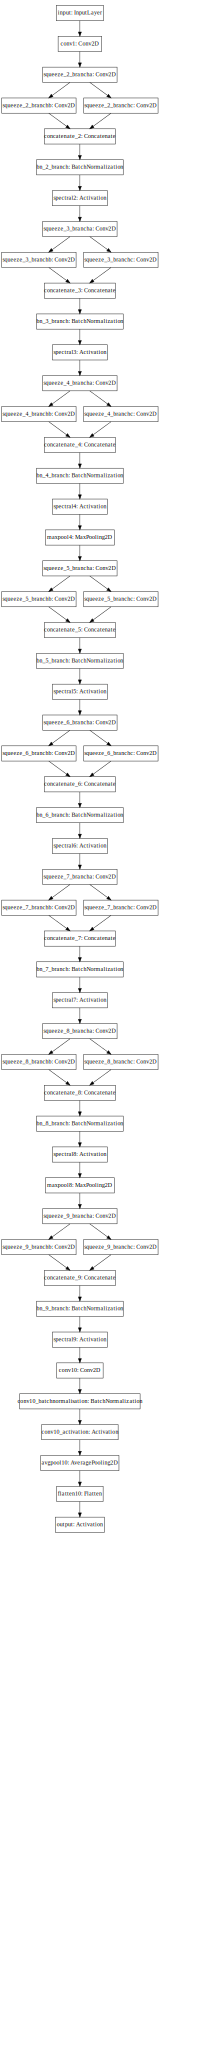

In [15]:
plot_model(model, to_file="6bands_v5-4.png",show_shapes=True,show_layer_names=True)
SVG(model_to_dot(model).create(prog="dot", format='svg'))

In [16]:
checkpoint = ModelCheckpoint("6bands_weights_v5-5_SC.h5", monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
logs = TensorBoard("6bands-logs-SC", histogram_freq=1)

In [17]:
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.10
   epochs_drop = 30.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

In [18]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

In [19]:
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)

In [20]:
train_labels_encoded = to_categorical(train_labels,num_classes=10)

classTotals = train_labels_encoded.sum(axis=0)
classWeight = {}

for i in range(len(classTotals)):
    classWeight[i] = classTotals.max()/classTotals[i]
    pass

classWeight

{0: 1.1985714,
 1: 1.1985714,
 2: 1.1985714,
 3: 1.4382857,
 4: 1.4382857,
 5: 1.7978572,
 6: 1.4382857,
 7: 1.1985714,
 8: 1.4382857,
 9: 1.0}

In [21]:
# opt = Adam(lr=1e-3)
# model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
opt = SGD(lr=1e-3, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['categorical_accuracy'])

# Training Model

In [23]:
epochs = 100
batchSize = 100

history = model.fit(train_generator,
                   steps_per_epoch = num_train_samples//batchSize,
                   epochs = epochs,
                   verbose = 1,
                   validation_data = val_generator,
                   validation_steps = num_val_samples//batchSize,
                   callbacks = [checkpoint, lrate, loss_history],
                   class_weight = classWeight
                   )

Epoch 1/100
193/193 [==============================] - ETA: 0s - loss: 2.3993 - categorical_accuracy: 0.5135
Epoch 00001: val_categorical_accuracy improved from -inf to 0.15455, saving model to 6bands_weights_v5-5_SC.h5
193/193 [==============================] - 62s 319ms/step - loss: 2.3993 - categorical_accuracy: 0.5135 - val_loss: 2.5022 - val_categorical_accuracy: 0.1545
Epoch 2/100
193/193 [==============================] - ETA: 0s - loss: 1.9729 - categorical_accuracy: 0.6104
Epoch 00002: val_categorical_accuracy improved from 0.15455 to 0.54364, saving model to 6bands_weights_v5-5_SC.h5
193/193 [==============================] - 61s 314ms/step - loss: 1.9729 - categorical_accuracy: 0.6104 - val_loss: 1.5377 - val_categorical_accuracy: 0.5436
Epoch 3/100
193/193 [==============================] - ETA: 0s - loss: 1.7199 - categorical_accuracy: 0.6565
Epoch 00003: val_categorical_accuracy improved from 0.54364 to 0.74727, saving model to 6bands_weights_v5-5_SC.h5
193/193 [=========

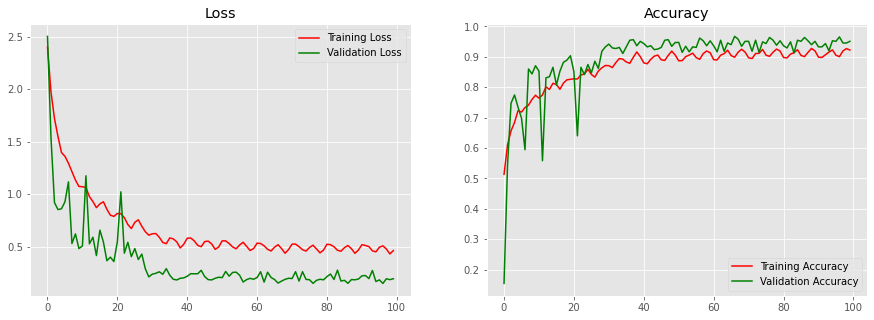

In [24]:
show_final_history(history)

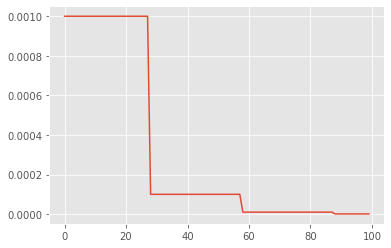

In [25]:
plot_learning_rate(loss_history)

In [26]:
def obtain_tif_images(csv_file):
    
    df = pd.read_csv(csv_file)
    num_samples = df.shape[0]
    
    X, y = [], []
    
    for i in tqdm(range(num_samples)):
        
        img_name = df.loc[i,'Filename']
        label = df.loc[i,'Label']

        src = rasterio.open(os.path.join(basePath,img_name))
        arr_3, arr_4, arr_8 = src.read(bands['3']), src.read(bands['4']), src.read(bands['8']) 
        arr_6, arr_7 = src.read(bands['6']), src.read(bands['7'])
        arr_11 = src.read(bands['11'])

        arr_3 = np.array(arr_3, dtype=np.float32)
        arr_4 = np.array(arr_4, dtype=np.float32)
        arr_6, arr_7 = np.array(arr_6, dtype=np.float32), np.array(arr_7, dtype=np.float32)
        arr_8 = np.array(arr_8, dtype=np.float32)
        arr_11 = np.array(arr_11, dtype=np.float32)

        arr_3 = Normalise(arr_3)
        arr_4 = Normalise(arr_4)
        arr_6, arr_7 = Normalise(arr_6), Normalise(arr_7)
        arr_8 = Normalise(arr_8)
        arr_11 = Normalise(arr_11)

        bands_10_20 = np.dstack((arr_3, arr_4, arr_6, arr_7, arr_8, arr_11))

        X.append(bands_10_20)
        y.append(label)
        
        pass
    
    X = np.array(X)
    y = np.array(y)
    
    return X,y
    pass

# Validation Phase

In [27]:
test_tifs, test_labels = obtain_tif_images(csv_file="../input/eurosat-dataset/EuroSATallBands/test.csv")

test_labels_encoded = to_categorical(test_labels, num_classes = len(class_names))

test_tifs.shape, test_labels.shape, test_labels_encoded.shape

100%|██████████| 2759/2759 [00:52<00:00, 52.17it/s]


((2759, 64, 64, 6), (2759,), (2759, 10))

In [28]:
test_pred = model.predict(test_tifs)
test_pred = np.argmax(test_pred, axis=1)
test_pred.shape

(2759,)

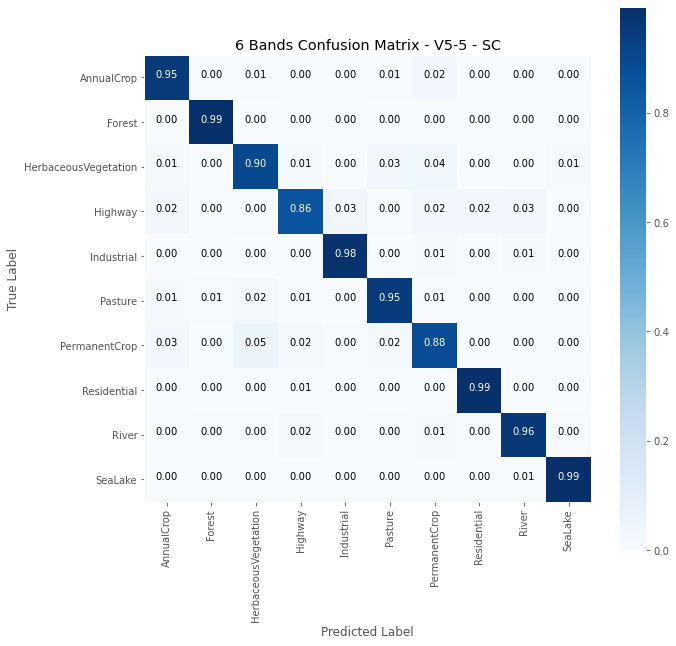

In [29]:
cnf_mat = confusion_matrix(test_labels, test_pred)

plot_confusion_matrix(cnf_mat, classes=class_names, title="6 Bands Confusion Matrix - V5-5 - SC")
plt.grid(False);

In [30]:
for f1,class_name in zip(f1_score(test_labels, test_pred, average=None), class_names):
    print("Class name: {}, F1 score: {:.3f}".format(class_name, f1))
    pass

Class name: AnnualCrop, F1 score: 0.945
Class name: Forest, F1 score: 0.990
Class name: HerbaceousVegetation, F1 score: 0.914
Class name: Highway, F1 score: 0.890
Class name: Industrial, F1 score: 0.972
Class name: Pasture, F1 score: 0.934
Class name: PermanentCrop, F1 score: 0.884
Class name: Residential, F1 score: 0.987
Class name: River, F1 score: 0.954
Class name: SeaLake, F1 score: 0.990


In [31]:
model.save("6bands_v5-5_SC.h5")

In [32]:
model_test = load_model("./6bands_v5-5_SC.h5")

model_test.summary()

Model: "SpectrumNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 64, 64, 6)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 96)   672         input[0][0]                      
__________________________________________________________________________________________________
squeeze_2_brancha (Conv2D)      (None, 32, 32, 16)   1552        conv1[0][0]                      
__________________________________________________________________________________________________
squeeze_2_branchb (Conv2D)      (None, 32, 32, 96)   1632        squeeze_2_brancha[0][0]          
________________________________________________________________________________________

In [33]:
model_test.load_weights("./6bands_weights_v5-5_SC.h5")

In [34]:
test_pred_2 = model_test.predict(test_tifs)
test_pred_2 = np.argmax(test_pred_2, axis=1)
test_pred_2.shape

(2759,)

In [35]:
for f1,class_name in zip(f1_score(test_labels, test_pred_2, average=None), class_names):
    print("Class name: {}, F1 score: {:.3f}".format(class_name, f1))
    pass

Class name: AnnualCrop, F1 score: 0.946
Class name: Forest, F1 score: 0.992
Class name: HerbaceousVegetation, F1 score: 0.912
Class name: Highway, F1 score: 0.888
Class name: Industrial, F1 score: 0.974
Class name: Pasture, F1 score: 0.931
Class name: PermanentCrop, F1 score: 0.888
Class name: Residential, F1 score: 0.987
Class name: River, F1 score: 0.952
Class name: SeaLake, F1 score: 0.990


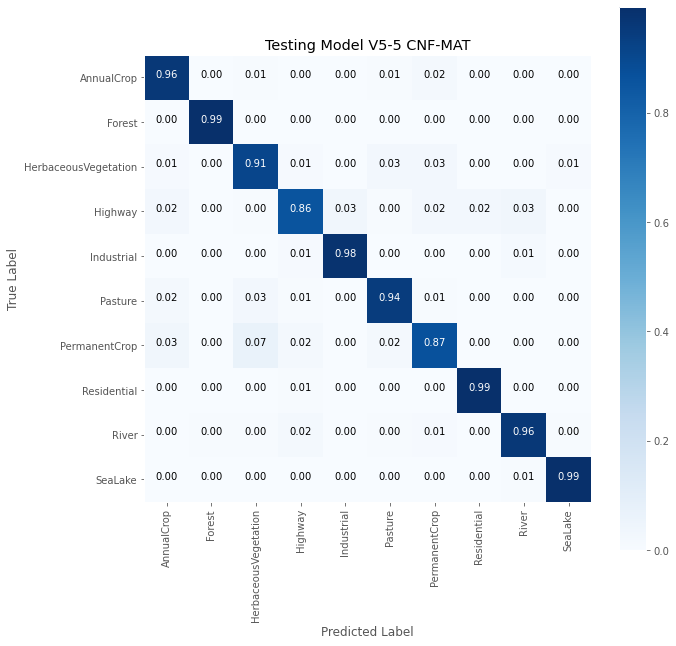

In [36]:
cnf_mat = confusion_matrix(test_labels, test_pred_2)

plot_confusion_matrix(cnf_mat, classes=class_names, title="Testing Model V5-5 CNF-MAT")
plt.grid(False)

In [37]:
val_tifs, val_labels = obtain_tif_images(csv_file="../input/eurosat-dataset/EuroSATallBands/validation.csv")

val_labels_encoded = to_categorical(val_labels, num_classes = len(class_names))

val_tifs.shape, val_labels.shape, val_labels_encoded.shape

100%|██████████| 5519/5519 [00:45<00:00, 120.85it/s]


((5519, 64, 64, 6), (5519,), (5519, 10))

In [38]:
val_pred = model_test.predict(val_tifs)
val_pred = np.argmax(val_pred, axis=1)
val_pred.shape

(5519,)

In [39]:
for f1,class_name in zip(f1_score(val_labels, val_pred, average=None), class_names):
    print("Class name: {}, F1 score: {:.3f}".format(class_name, f1))
    pass

Class name: AnnualCrop, F1 score: 0.932
Class name: Forest, F1 score: 0.989
Class name: HerbaceousVegetation, F1 score: 0.912
Class name: Highway, F1 score: 0.896
Class name: Industrial, F1 score: 0.959
Class name: Pasture, F1 score: 0.942
Class name: PermanentCrop, F1 score: 0.867
Class name: Residential, F1 score: 0.980
Class name: River, F1 score: 0.959
Class name: SeaLake, F1 score: 0.992
